## Click Prediction

This is a toy demo to show the overall process. This should not be expected to product accurate click predictions.

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix


import sys
sys.path.insert(0,'../..')

from api import *

## Services available:

* gscservice: Google Search Console
* gaservice: Google Analytics.  A wrapper around https://github.com/debrouwere/google-analytics.
* semrushservice: SEM Rush. A port of https://github.com/storerjeremy/python-semrush.
* watsonservice: IBM Watson API.  Pulls keywords and entities for a given html

## 1) Get GSC Data

In [58]:
gsc_profile = 'https://www.domain.com'
days_back = 180

# Combine the dataframe by nquery and page.
def combine_gsc(df):
    
    df = df.groupby(['query'], as_index=False).agg({"impressions": "sum","clicks":"sum","position": "mean"})
        
    df['ctr'] = df['clicks']/df['impressions']
    df['position'] = df['position'].astype(int)
    df = df.round({'ctr': 2})
    return df

df = gscservice.get_site_data(gsc_profile, days_back, output_fn="demo3.csv")

df = combine_gsc(df).reset_index()
#Reduce to top queries by clicks
df = df[df.clicks > 5]
df.shape

Reloading Existing: demo3.csv


(2055, 6)

## 2) Set Up DataLoader

In [ ]:
import dataset

features = df[['position','impressions']]
labels = df[['clicks']]

def apply_embed(row):
    embed = row['embedding']
    for i, e in enumerate(embed):
        row['e_'+str(i)] = e
    return row

data_loader_bert, df_bert = dataset.load_bert_df(input_df=df, input_row="query")
df_bert_embed = df_bert.apply(apply_embed,axis=1).drop(columns=['embedding','linex_index','tokens'])

features = pd.concat([features.reset_index(drop =True), df_bert_embed.reset_index(drop =True)], axis=1)

data_loader = dataset.load_pandas(features, labels, batch_size=32, shuffle=True, drop_last=True)

## 3) Set up Model

In [70]:
torch.manual_seed(123)

# Make it
model = torch.nn.Sequential(
    torch.nn.Linear(770, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1),
)

# Optimizing options
loss_function =  nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

# Number of Epochs
n_epochs = 500

## 4) Train

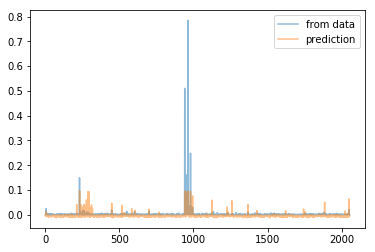

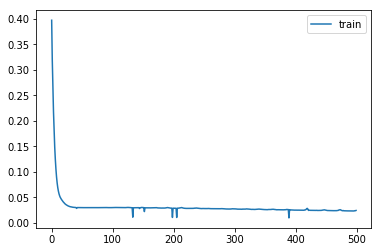

In [71]:

loss_list  = []

for epoch in range(n_epochs):
    
    epoch +=1
    
    epoch_loss = 0
    optimizer.zero_grad()
    
    for x, y in data_loader:
        
        p_y = model(x)
        
        loss = loss_function(p_y, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.data[0]
        
    #print('epoch {}, loss {}'.format(epoch,epoch_loss))
    loss_list.append(epoch_loss)
    

x_train = data_loader.dataset.tensors[0]
predicted =model(x_train).data.numpy()
y_correct = data_loader.dataset.tensors[1].data.numpy()


plt.plot(y_correct, label = 'from data', alpha = .5)
plt.plot(predicted, label = 'prediction', alpha = 0.5)
plt.legend()
plt.show()
#print(model.state_dict())

plt.plot(loss_list, label = 'train')
plt.legend();

In [ ]:
predictions = [{'pred': float(x[0]), 'act':float(act_list[i][0])} for i, x in enumerate(pred_list)]

In [ ]:
# Click predictions vs actual if prediction >= 10. 
predictions